In [296]:
from scattnlay import scattnlay, fieldnlay
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time 

In [297]:
help(scattnlay)

Help on function scattnlay in module scattnlay.main:

scattnlay(x, m, theta=array([], dtype=float64), nmax=-1, pl=-1, mp=False)
    scattnlay(x, m[, theta, nmax, pl, mp])
    
    Calculate the actual scattering parameters and amplitudes.
    
        x: Size parameters (1D or 2D ndarray)
        m: Relative refractive indices (1D or 2D ndarray)
        theta: Scattering angles where the scattering amplitudes will be
               calculated (optional, 1D ndarray)
        nmax: Maximum number of multipolar expansion terms to be used for the
              calculations. Only use it if you know what you are doing.
        pl: Index of PEC layer. If there is none just send -1.
        mp: Use multiple (True) or double (False) precision.
    
    Returns: (terms, Qext, Qsca, Qabs, Qbk, Qpr, g, Albedo, S1, S2)
    with
        terms: Number of multipolar expansion terms used for the calculations
        Qext: Efficiency factor for extinction
        Qsca: Efficiency factor for scattering
  

In [298]:
def scattnlay_wrap(size, wavelength, theta): # returns scattering amplitudes & cross-sections for water droplets
    x = get_x(size, wavelength)
    m = complex(1.33 + 0.0j) # water
    terms, Qext, Qsca, Qabs, Qbk, Qpr, g, Albedo, S1, S2 = scattnlay(np.array([x]), np.array([m]), theta)
    sigma_t = Qsca*np.pi*(size/2)**2
    return sigma_t, S1, S2

def get_x(size, wavelength): # returns size parameter of droplet diameter size
    return size*np.pi/wavelength
                   
def get_theta(deg_step):
    return np.arange(0, np.pi, np.radians(deg_step))

def get_phi(deg_step):
    return np.arange(0, 2*np.pi, np.radians(deg_step))

def phase_function(S1, S2): # unpolarised 
    return abs(S1)**2+abs(S2)**2

def theta_normalisation(y, theta):
    return np.trapz(y*np.sin(theta), theta)*2*np.pi

def differential_sigma(size, wavelength, theta):
    sigma_t, S1, S2 = scattnlay_wrap(size, wavelength, theta)
    p = phase_function(S1, S2)
    N = theta_normalisation(p, theta)
    return sigma_t*p/N

def get_size_range(min_um, max_um, um_step):
    return np.arange(min_um*10**-6, max_um*10**-6, um_step*10**-6) 

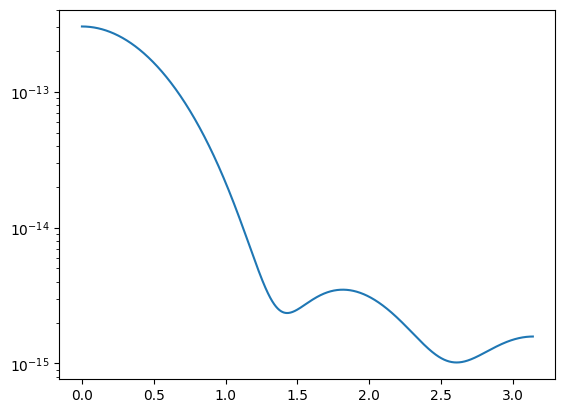

In [299]:
size = 0.26*2*10**-6
wavelength = 550e-9 
theta = get_theta(0.1)

s = differential_sigma(size, wavelength, theta)
plt.yscale("log")
plt.plot(theta, s)

In [328]:
def sint_sphere(theta, phi, integrand): # soild angle integration over sphere
    integrand = integrand*np.array([np.sin(theta)]*np.size(phi)) # theta x phi numerical integrand array
    return np.trapz(np.trapz(integrand, theta), phi)

def sint_theta(theta, theta_curve, theta1, theta2): # solid angle integration over theta range
    # get numerical range
    (index1, theta1) = min(enumerate(theta), key=lambda x: abs(theta1 - x[1])) 
    (index2, theta2) = min(enumerate(theta), key=lambda x: abs(theta2 - x[1]))
    curve_range = theta_curve[index1:index2+1]
    theta_range = theta[index1:index2+1]
    # integrate numerical range
    return np.trapz(curve_range*np.sin(theta_range), theta_range)*2*np.pi
    
t0 = time.time()
min_um, max_um, um_step = 1, 50, 0.05
wavelength = 632.8e-9 # FSSP
theta1, theta2 = np.radians(4.6), np.radians(12.8)  # FSSP
deg_step = 0.5

size_range = get_size_range(min_um, max_um, um_step)
theta = get_theta(deg_step)
d_sigmas_fssp = list(map(lambda x: differential_sigma(x, wavelength, theta), size_range))
t1 = time.time()
print(t1-t0)

92.14854288101196


0.16101503372192383


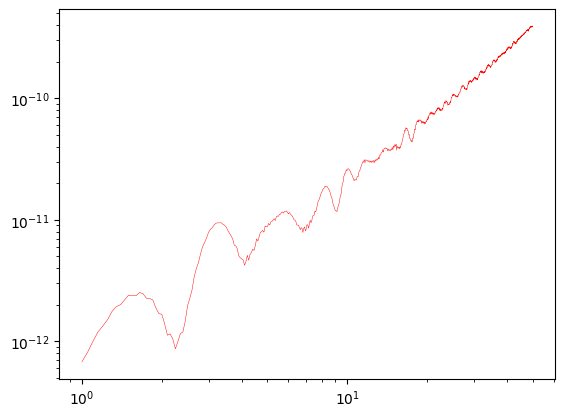

In [329]:
t0 = time.time()
int_sigmas_fssp = list(map(lambda x: sint_theta(theta, x, theta1, theta2), d_sigmas_fssp))
t1 = time.time()
print(t1-t0)

plt.yscale("log")
plt.xscale("log")
plt.plot(size_range*10**6, int_sigmas_fssp, linewidth=0.33, color="red")

In [330]:
def collection_map(theta, phi, collection_direction, collection_angle): # collection optic half angle
    u = np.transpose(spherical_unit(theta, phi)) # gives (THETA, PHI, u) for meshgrid (THETA, PHI)
    dotp = np.round(np.dot(u, collection_direction),15) # round for precision 
    return np.less(np.arccos(dotp), collection_angle)
    
def spherical_unit(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array([x,y,z])

t0 = time.time()
deg_step = 0.5
theta = get_theta(deg_step)
phi = get_phi(deg_step)
theta1, theta2  = np.radians(144), np.radians(156) # BCP
collection_angle = (theta2 - theta1)/2
collection_theta = (theta2 + theta1)/2
collection_direction = spherical_unit(collection_theta, 0)

THETA, PHI = np.meshgrid(theta, phi, indexing='ij') 
collection_map = collection_map(THETA, PHI, collection_direction, collection_angle)
t1 = time.time()
print(t1-t0)

0.019077777862548828


In [331]:
t0 = time.time()
min_um, max_um, um_step = 1, 50, 0.05
wavelength = 658e-9 # BCP
size_range = get_size_range(min_um, max_um, um_step)
d_sigmas_bcp = list(map(lambda x: differential_sigma(x, wavelength, theta), size_range))
t1 = time.time()
print(t1-t0)

86.47455906867981


2.1297738552093506


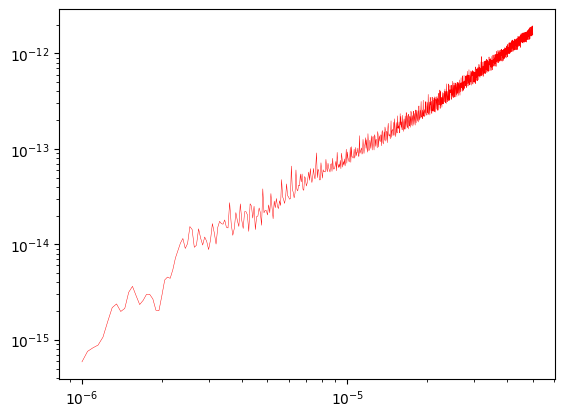

In [332]:
def get_integrand(d_sigma, collection_map):
    rows = np.shape(collection_map)[0]
    return np.array([d_sigma]*rows)*collection_map

t0 = time.time()
integrands = list(map(lambda x: get_integrand(x,collection_map), d_sigmas_bcp))                    
int_sigmas_bcp = list(map(lambda x: sint_sphere(theta, phi, x), integrands))
t1 = time.time()
print(t1-t0)

plt.yscale("log")
plt.xscale("log")
plt.plot(size_range, int_sigmas_bcp, linewidth=0.33, color="red")